# Generative Models PHW4: Energy-Based Models

Name: Firoozeh Abrishami

Student ID: 402208716

## Setup

In [71]:
# Import necessary libraries
import random
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

In [72]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (10 points)

Load the `MNIST` dataset and normalize the images between -1 and 1 as this makes the implementation easier.

In [73]:
# TODO: Define transformations and set the batch size
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])
batch_size = 64

# TODO: Load train and test datasets
trainset = MNIST(root='./data', train=True, download=True, transform=transform)
testset = MNIST(root='./data', train=False, download=True, transform=transform)

# TODO: Load the train and test loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Langevin Dynamics (20 points)

The Langevin dynamics in our case starts with a randomly initialized $x_0$ and then uses the information about the landscape of the energy function
(i.e., the gradient) to seek for new $x$, that is:
$$x_{t+1} = x_{t} + \alpha \nabla_{x_t}\text{LogSumExp} \left[f_{\theta} (x) \right] + \sigma \cdot \epsilon$$

where $\alpha, \sigma > 0$ and $\epsilon \sim \mathcal{N}(0, I)$. The Langevin dynamics could be seen as the stochastic gradient descent in the observable space with a small Gaussian noise added at each step.

Our goal is to run the Langevin dynamics for $\eta$ iterations with the steps size $\alpha$ and the noise level equal $\sigma$.

In [74]:
def energy_gradient(model, x):
    # TODO: Set model to evaluation mode
    model.eval()

    # TODO: Copy the original data and make it require gradients
    x = x.clone().detach().requires_grad_(True)

    # TODO: Calculate the gradient
    output = model(x)
    log_sum_exp = torch.logsumexp(output, dim=1)  # Assuming output has a batch dimension
    grad = torch.autograd.grad(log_sum_exp.sum(), x)[0]  # sum() ensures a scalar for gradient computation

    # TODO: Set model to training mode
    model.train()

    # TODO: Return the gradients
    return grad

In [75]:
def langevin_dynamics_step(model, x, alpha, sigma):
    # Calculate gradient w.r.t. x
    gradient = energy_gradient(model, x)

    # Sample epsilon ~ Normal(0, I)
    epsilon = torch.randn_like(x)  # randn_like creates tensor with same shape as x, filled with random numbers from a normal distribution

    # Generate a new sample
    x_new = x + alpha * gradient + sigma * epsilon

    # Return the new sample
    return x_new

# Sampling (15 points)

In [76]:
def sample(model, eta, alpha, sigma, current_batch_size):
    # Sample x0 from uniform [-1, +1]
    x = torch.rand(current_batch_size, 28*28, device=device) * 2 - 1  # batch_size from previous code

    # Run Langevin Dynamics η times
    for _ in range(eta):
        x = langevin_dynamics_step(model, x.view(x.size(0),1,28,28), alpha, sigma)

    # Return the result
    return x.view(current_batch_size, 1, 28, 28)

# Loss (15 points)

We can evaluate our model using the following objective:

$$\mathcal{L} = \mathcal{L}_\text{clf}(\theta) + \mathcal{L}_\text{gen}(\theta)$$

Where $\mathcal{L}_\text{clf}(\theta)$ is the cross-entropy loss and $\mathcal{L}_\text{gen}(\theta)$ is an approximation to the log-marginal distribution over images (for example the LogSumExp loss).

In [77]:
def loss_function(model, eta, alpha, sigma, x, y_pred, y_true):
    # TODO: Calculate the discriminative loss: the cross-entropy
    discriminative_loss = F.cross_entropy(y_pred, y_true)

    # TODO: Calculate the generative loss: E(x) - E(x_sample)
    x_sample = sample(model, eta, alpha, sigma, x.size(0))
    energy_real = model(x).logsumexp(dim=1)
    energy_sample = model(x_sample).logsumexp(dim=1)
    generative_loss = -energy_real + energy_sample

    # TODO: Return the total loss
    total_loss = (discriminative_loss + generative_loss).mean()

    return total_loss

# Neural Network (10 points)

Define the neural network that specifies the energy function.
The inputs should be images and the outputs must be the classes.
Don't forget to use appropriate activation functions!

In [78]:
class EnergyNet(nn.Module):
    def __init__(self):
        super(EnergyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 512),
            # nn.ReLU(),
            nn.ELU(),
            nn.Linear(512, 28*28),
            nn.ELU(),
            # nn.ReLU(),
            # nn.Unflatten(1, (1, 28, 28)),  # Reshape to (batch_size, 1, 28, 28)
            # nn.Conv2d(1, 10, kernel_size=1, stride=1, padding=0),
            # nn.ReLU(),
            # nn.Flatten(),  # Flatten again after Conv2d
            nn.Linear(28 * 28, 10),
            # nn.Flatten(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.net(x)

# Visualize (15 points)

Create the following functions to be able to visualize real and generated images.

In [79]:
def visualize_real(loader):
    # Get a batch of real images and labels from the loader
    dataiter = iter(loader)  # Create an iterator for the loader
    images, labels = next(dataiter)  # Get the next batch of data

    # Display the images with labels
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))  # Create a grid of subplots
    for i, ax in enumerate(axes.flat):
        # Denormalize the image for display
        image = images[i].numpy() * 0.5 + 0.5  # Reverse the normalization
        image = image.reshape(28, 28)  # Reshape to the original image size

        # Display the image
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_generated(model, eta, alpha, sigma):
    # Generate samples using the EBM
    generated_samples = sample(model, eta, alpha, sigma, 64)

    # Display the generated samples
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        # Denormalize the image for display (if needed)
        image = generated_samples[i].cpu().detach().numpy()  # Detach from computation graph and move to CPU
        image = image.reshape(28, 28)  # Reshape if needed

        # Display the image
        ax.imshow(image, cmap='gray')  # Assuming grayscale images
        ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Training (15 points)

Fill in the evaluation and training functions. Make sure you track the loss and plot it to analyze possible issues.

In [80]:
def eval_ebm(model, loader, eta, alpha, sigma):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0
    total_loss = 0  # Initialize total loss

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # Forward pass through the model
            logits = model(x)
            predictions = logits.argmax(dim=1)

            # Calculate loss (using cross-entropy for example)
            loss = F.cross_entropy(logits, y)
            total_loss += loss.item() * y.size(0)  # Accumulate loss for the batch

            # Calculate accuracy
            total_correct += (predictions == y).sum().item()
            total_samples += y.size(0)

    # Compute average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples * 100
    # print(f"Evaluation Accuracy: {accuracy:.2f}%")

    # Return both loss and accuracy
    return avg_loss, accuracy

In [81]:
def train_ebm(model, optimizer, loader, epochs, eta, alpha, sigma):
    model.train()  # Set model to training mode
    loss_history = []
    val_losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        total_correct = 0
        total_samples = 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)
            current_batch_size = x.size(0)  # Get current batch size

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(x)
            predictions = logits.argmax(dim=1)

            # Langevin dynamics to sample images
            x_sample = sample(model, eta, alpha, sigma, current_batch_size)

            # Compute loss
            loss = loss_function(model, eta, alpha, sigma, x, logits, y)
            epoch_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy for the batch
            total_correct += (predictions == y).sum().item()
            total_samples += y.size(0)

        # Average loss for the epoch
        epoch_loss /= len(loader)
        loss_history.append(epoch_loss)

        # Accuracy for the epoch
        accuracy = total_correct / total_samples * 100

        val_loss, val_acc = eval_ebm(model, testloader, eta, alpha, sigma)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n")

        if (epoch + 1) % 5 == 0:
            visualize_generated(model, eta, alpha, sigma)

    return loss_history, val_losses


Now define the optimizer and train your model.

Epoch 1/20, Train Loss: 0.4356, Accuracy: 72.02 | Val Loss: 0.9221 | Val Acc: 79.2000

Epoch 2/20, Train Loss: 0.0387, Accuracy: 77.52 | Val Loss: 0.8932 | Val Acc: 75.6600

Epoch 3/20, Train Loss: 0.8149, Accuracy: 80.95 | Val Loss: 1.4353 | Val Acc: 80.8600

Epoch 4/20, Train Loss: 0.7043, Accuracy: 87.18 | Val Loss: 0.4255 | Val Acc: 92.4800

Epoch 5/20, Train Loss: 0.4545, Accuracy: 87.86 | Val Loss: 0.6167 | Val Acc: 91.1600



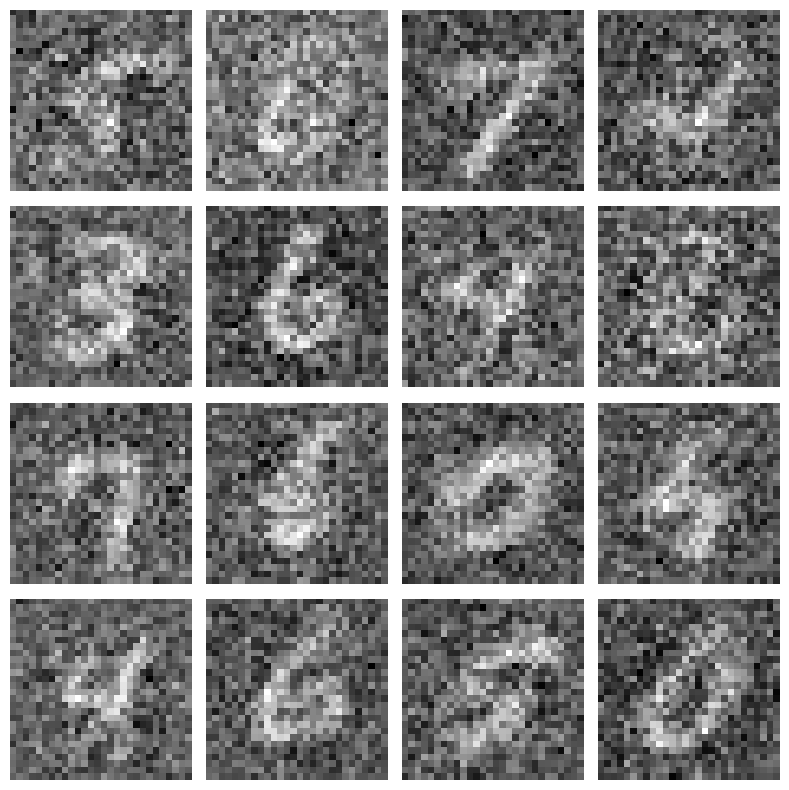

Epoch 6/20, Train Loss: 0.6761, Accuracy: 92.09 | Val Loss: 0.4106 | Val Acc: 93.2400

Epoch 7/20, Train Loss: 0.6153, Accuracy: 93.47 | Val Loss: 0.3052 | Val Acc: 94.6700

Epoch 8/20, Train Loss: 0.4540, Accuracy: 94.31 | Val Loss: 0.4061 | Val Acc: 94.1400

Epoch 9/20, Train Loss: 0.4096, Accuracy: 94.94 | Val Loss: 0.1953 | Val Acc: 95.5800

Epoch 10/20, Train Loss: 0.3199, Accuracy: 94.67 | Val Loss: 0.2067 | Val Acc: 95.9900



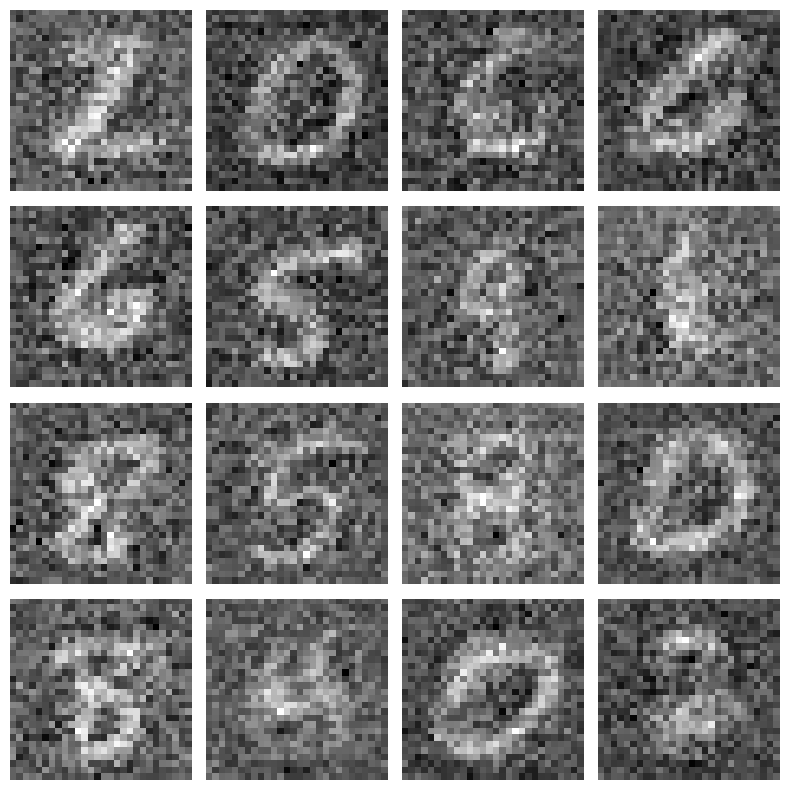

Epoch 11/20, Train Loss: 0.3089, Accuracy: 95.16 | Val Loss: 0.4677 | Val Acc: 95.4300

Epoch 12/20, Train Loss: 0.5171, Accuracy: 95.43 | Val Loss: 0.2751 | Val Acc: 96.3000

Epoch 13/20, Train Loss: 0.3022, Accuracy: 95.43 | Val Loss: 0.4086 | Val Acc: 95.4100

Epoch 14/20, Train Loss: 0.3104, Accuracy: 95.16 | Val Loss: 0.4181 | Val Acc: 95.3400

Epoch 15/20, Train Loss: 0.3945, Accuracy: 95.44 | Val Loss: 0.2507 | Val Acc: 96.1800



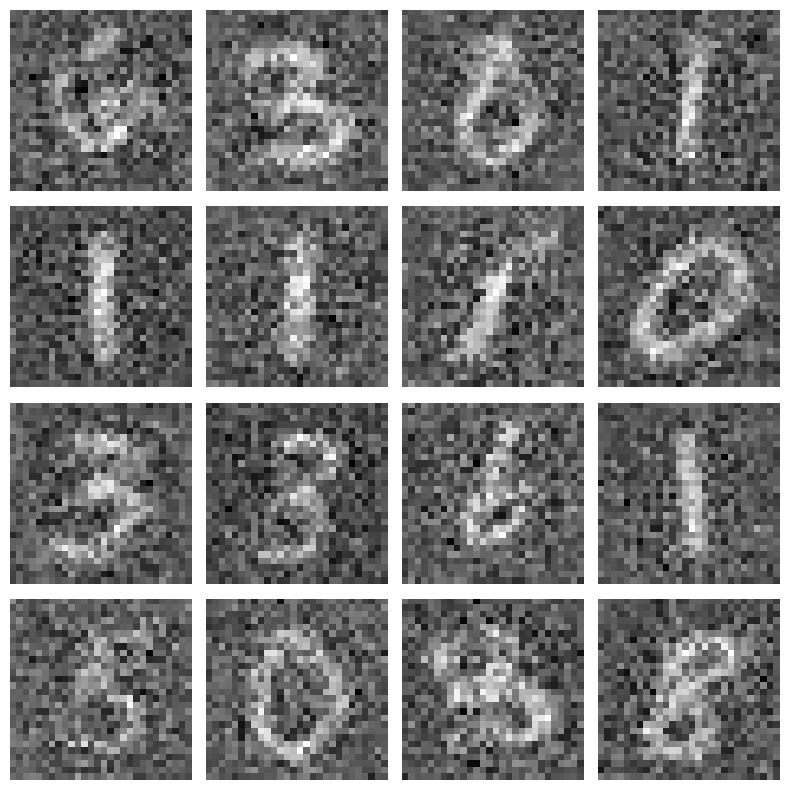

Epoch 16/20, Train Loss: 0.5220, Accuracy: 95.71 | Val Loss: 0.3273 | Val Acc: 95.9200

Epoch 17/20, Train Loss: 0.3880, Accuracy: 95.76 | Val Loss: 0.3744 | Val Acc: 93.9300

Epoch 18/20, Train Loss: 0.3242, Accuracy: 95.50 | Val Loss: 0.4479 | Val Acc: 95.2600

Epoch 19/20, Train Loss: 0.6166, Accuracy: 95.90 | Val Loss: 0.2170 | Val Acc: 96.3700

Epoch 20/20, Train Loss: 0.5382, Accuracy: 95.92 | Val Loss: 0.2363 | Val Acc: 96.1400



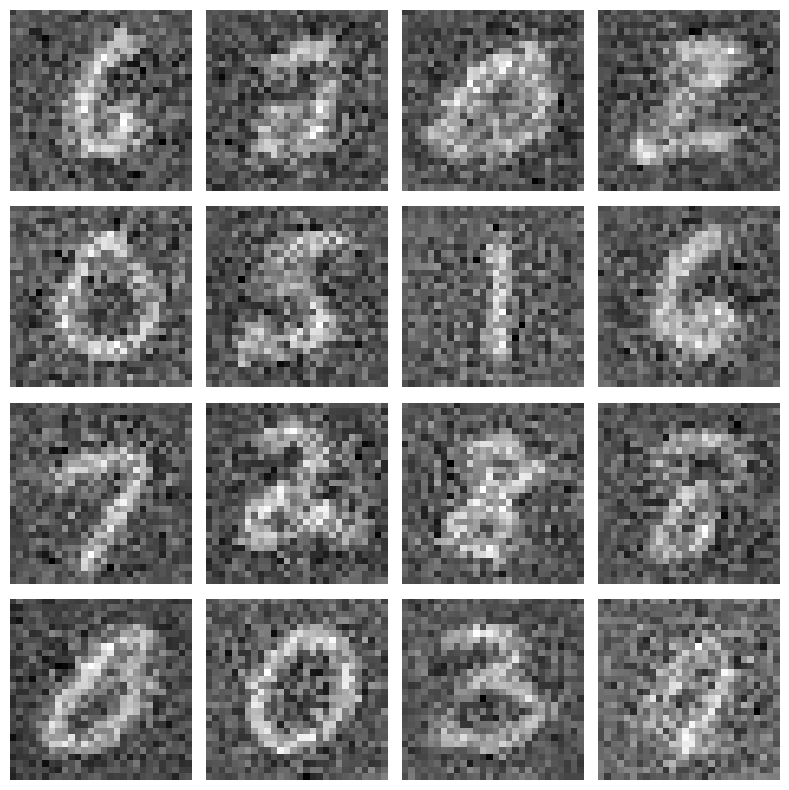

In [82]:
# TODO: Train your EBM

model = EnergyNet().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters for Langevin dynamics
eta = 50  # Number of Langevin steps
alpha = 0.1  # Step size
sigma = 0.05  # Noise level

# Train the model
epochs = 20  # Number of training epochs
train_losses, val_losses = train_ebm(model, optimizer, trainloader, epochs, eta, alpha, sigma)


Plot the training curve.

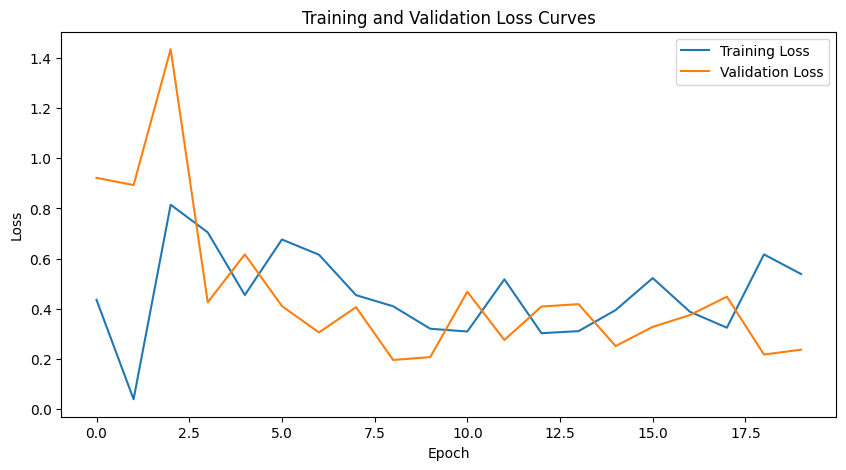

In [83]:
# TODO: Plot loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

Now visualize generated samples. (You can visualize images every few epochs to see the evolution of your network)

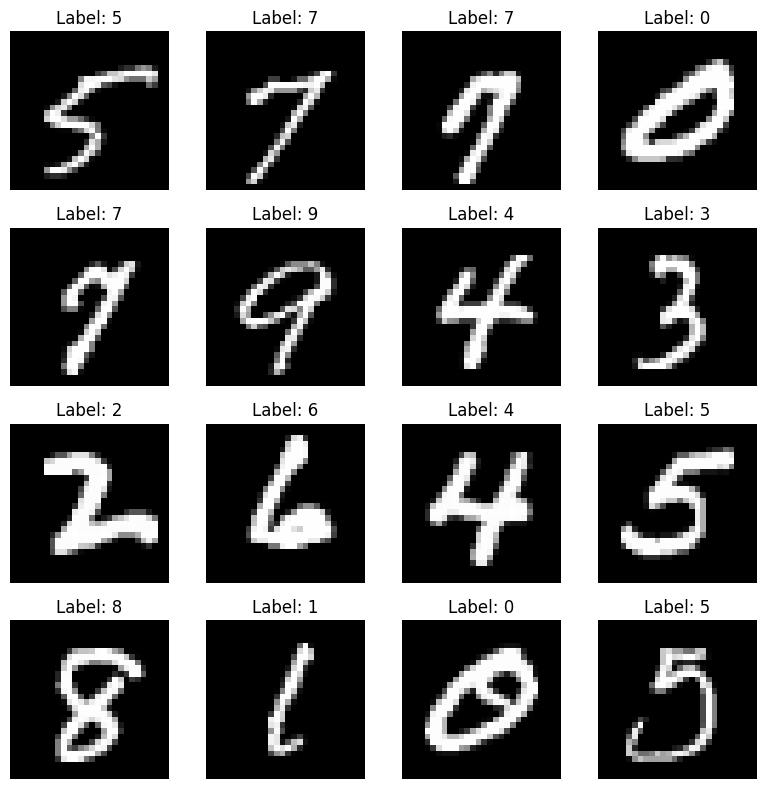

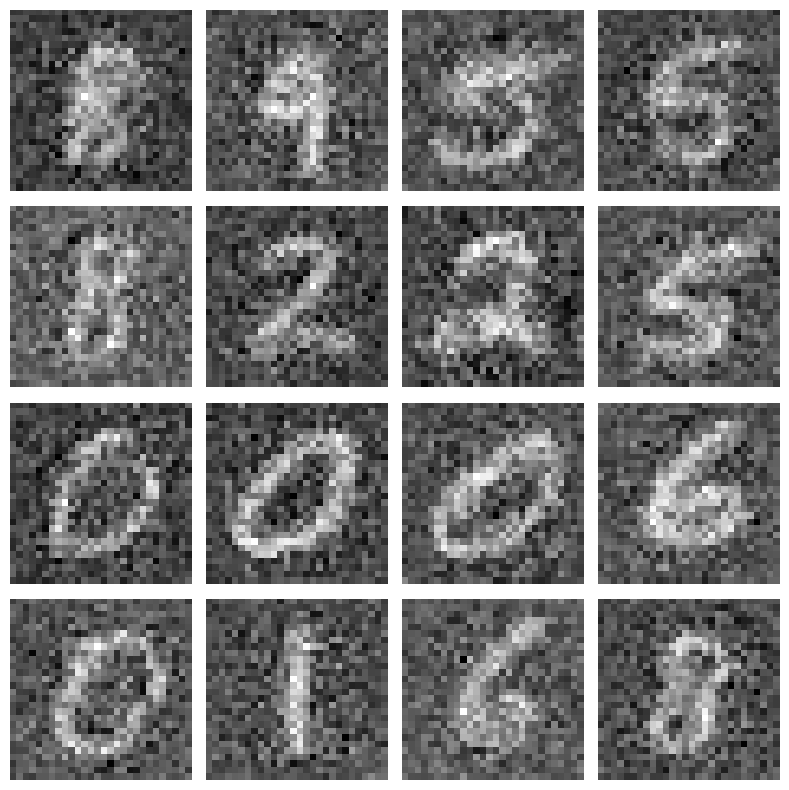

In [84]:
# TODO: Generate and visualize images
accuracy = eval_ebm(model, testloader, eta=50, alpha=alpha, sigma=sigma)
visualize_real(trainloader)
visualize_generated(model, eta, alpha, sigma)

If your resutls aren't great you can tune the hyperparameters to get better results or alternatively you can modify the dataset (resize, ...)to make it easier to learn the energy function.